[*********************100%%**********************]  1 of 1 completed
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 33.7 K
1 | criterion | MSELoss   | 0     
----------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total params
0.135     Total estimated model params size (MB)


Epoch 149: 100%|██████████| 123/123 [00:00<00:00, 131.39it/s, v_num=pvcu, train_loss_step=0.0304, val_loss_step=1.760, val_loss_epoch=1.150, train_loss_epoch=0.053]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 123/123 [00:01<00:00, 93.17it/s, v_num=pvcu, train_loss_step=0.0304, val_loss_step=1.760, val_loss_epoch=1.150, train_loss_epoch=0.053] 


Restoring states from the checkpoint path at .\RNN_single_step_forecasts\ue0vpvcu\checkpoints\epoch=149-step=18450.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\RNN_single_step_forecasts\ue0vpvcu\checkpoints\epoch=149-step=18450.ckpt


Testing DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 205.81it/s]

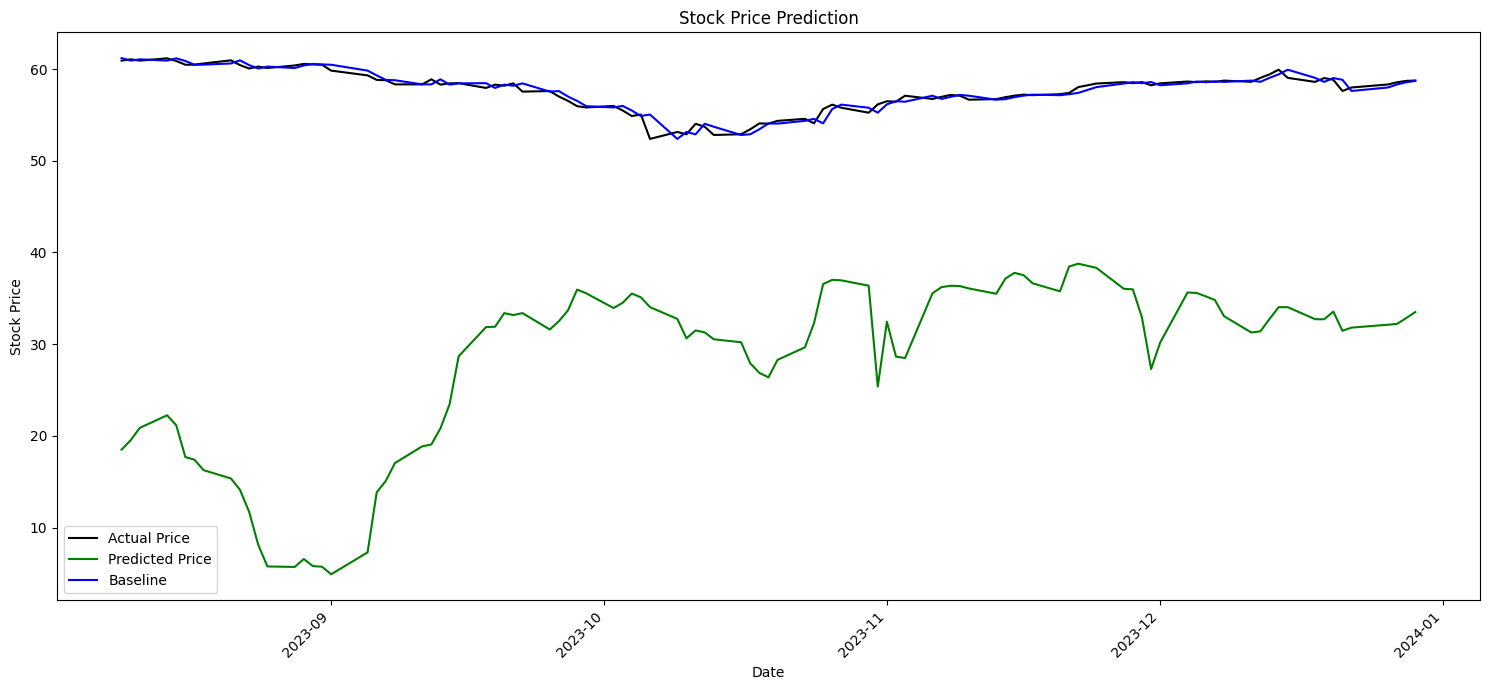

Testing DataLoader 0: 100%|██████████| 15/15 [00:01<00:00, 10.42it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5368765592575073
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
train_loss_epoch,█▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▂▁▁
train_loss_step,▁▄▇█▃▂▂▁▄▁█▂▄▄▁▁▁▄▂▃▆▁▁▁▂▂▂▂▁▁▃▂▂▁▁▂▂▂▁▁
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▃▁▄▄▁▁▄▁▂▂▂▂▂▂▂▂▇▂▇▇▂▂█▂▂▂▂▂▂▂
val_loss_epoch,▅▆▆▇▇▇▇▇▅█▆▃▂▁▁▁▁▂▂▁▂▂▂▃▃▄▃▄▃▅▆▅▇██▇▆▄▆█
val_loss_step,▆▇▇▇████▃█▅▂▂▁▂▂▂▂▃▃▄▅▅▅▅▆▅▅▅▅▅▅▅▄▃▄▃▂▄▃
epoch,150
test_loss,1.53688
train_loss_epoch,0.05297
train_loss_step,0.03038


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import wandb
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from models import RNNModel, LSTMModel, GRUModel
from config import architecture, seq_length, num_epochs, learning_rate, wandb_config, model_config
from preprocessing import stock_df, features_df


class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, feature_scaler, label_scaler, train_loader, val_loader, test_loader, test_dates):
        super().__init__()
        self.model = model
        self.feature_scaler = feature_scaler
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.test_dates = test_dates
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).detach().cpu().numpy())
            actuals.extend(labels.view(-1).detach().cpu().numpy())

        predictions_original_scale = list(self.label_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
        actuals_original_scale = list(self.label_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())
        baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]

        """
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())
        
        # The second column (index 1) constains the t_close_t_open prices which I consider as the most valuable feature for comparing the predictions of our model
        predictions = np.array(predictions)
        dummy_array = np.zeros((len(predictions), len(self.scaler_scale)))
        dummy_array[:, 1] = predictions
        predictions_original_scale = list(self.scaler.inverse_transform(dummy_array)[:, 1])

        print(len(self.scaler_scale))

        actuals = np.array(actuals)
        dummy_array = np.zeros((len(actuals), len(self.scaler_scale)))
        dummy_array[:, 1] = actuals
        actuals_original_scale = list(self.scaler.inverse_transform(dummy_array)[:, 1])

        baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]
        """

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(self.test_dates[-100:], actuals_original_scale[-100:], label='Actual Price', color='black', linestyle='-')
        ax.plot(self.test_dates[-100:], predictions_original_scale[-100:], label='Predicted Price', color='green', linestyle='-')
        ax.plot(self.test_dates[-100:], baseline_original_scale[-100:], label='Baseline', color='blue', linestyle='-')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.plot()
        plt.show()
        
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actuals_original_scale = np.array(actuals_original_scale)
        predictions_original_scale = np.array(predictions_original_scale)
        baseline_original_scale = np.array(baseline_original_scale)

        model_mse = mean_squared_error(actuals_original_scale, predictions_original_scale)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actuals_original_scale, predictions_original_scale)
        model_r2 = r2_score(actuals_original_scale, predictions_original_scale)
        model_mape = np.mean(np.abs((actuals_original_scale - predictions_original_scale) / actuals_original_scale))
        
        baseline_mse = mean_squared_error(actuals_original_scale, baseline_original_scale)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actuals_original_scale, baseline_original_scale)
        baseline_r2 = r2_score(actuals_original_scale, baseline_original_scale)
        baseline_mape = np.mean(np.abs((actuals_original_scale - baseline_original_scale) / (actuals_original_scale + 1e-8)))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
        }

        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
        }

        model_baseline_performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
        }

        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "model-baseline performance comparison [%]"])
        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], model_baseline_performance_metrics[metric])
        wandb.log({"metrics": metrics_table})


def create_sequences(data, labels):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = labels[i + seq_length - 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)

def flatten_cyclic_features(df, feature_name):
    # Create separate columns for the cosine and sine values
    df[f'{feature_name}_cos'] = df[feature_name].apply(lambda x: x[0])
    df[f'{feature_name}_sin'] = df[feature_name].apply(lambda x: x[1])
    # Drop the original column containing the lists
    df.drop(feature_name, axis=1, inplace=True)
    return df

def load_data():
    normalized_features_df = features_df.copy()
    labels = stock_df['Close'].values
    cyclic_features = ['month_of_year', 'week_of_year', 'day_of_year', 'day_of_month', 'day_of_week']
    for feature in cyclic_features:
        normalized_features_df = flatten_cyclic_features(normalized_features_df, feature)

    total_length = len(normalized_features_df)
    split_idx = int(total_length * 0.8) + seq_length
    val_test_idx = int(total_length * 0.9) + seq_length

    train_df = normalized_features_df.iloc[:split_idx]
    val_df = normalized_features_df.iloc[split_idx:val_test_idx]
    test_df = normalized_features_df.iloc[val_test_idx:]

    train_labels = labels[:split_idx]
    val_labels = labels[split_idx:val_test_idx]
    test_labels = labels[val_test_idx:]

    feature_scaler = MinMaxScaler(feature_range=(-1, 1))
    train_normalized = feature_scaler.fit_transform(train_df)
    val_normalized = feature_scaler.transform(val_df)
    test_normalized = feature_scaler.transform(test_df)

    label_scaler = MinMaxScaler(feature_range=(-1, 1))
    train_labels_scaled = label_scaler.fit_transform(train_labels.reshape(-1, 1))
    val_labels_scaled = label_scaler.transform(val_labels.reshape(-1, 1))
    test_labels_scaled = label_scaler.transform(test_labels.reshape(-1, 1))

    X_train, y_train = create_sequences(train_normalized, train_labels_scaled.flatten())
    X_val, y_val = create_sequences(val_normalized, val_labels_scaled.flatten())
    X_test, y_test = create_sequences(test_normalized, test_labels_scaled.flatten())


    """
    split_idx = int(len(normalized_features_df) * 0.8) + seq_length
    train_df = normalized_features_df.iloc[:split_idx]
    temp_df = normalized_features_df.iloc[split_idx:]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_normalized = scaler.fit_transform(train_df)

    X_train, y_train = create_sequences(train_normalized)

    scaler_scale = scaler.scale_.copy()  # save scale
    scaler_min = scaler.min_.copy()  # save min

    temp_normalized = scaler.transform(temp_df)
    X_temp, y_temp = create_sequences(temp_normalized)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    """


    test_dates = normalized_features_df.index[-(len(X_test) + seq_length):].tolist()
    test_dates = test_dates[seq_length:]
    
    train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False, 
                                               num_workers=15, persistent_workers=True)
    val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False, 
                                             num_workers=15, persistent_workers=True)
    test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False, 
                                              num_workers=15, persistent_workers=True)

    return train_loader, val_loader, test_loader, feature_scaler, label_scaler, test_dates


def main():
    torch.set_float32_matmul_precision("medium")
    wandb_logger = WandbLogger(project="RNN_single_step_forecasts", log_model="all", config=wandb_config)
    train_loader, val_loader, test_loader, feature_scaler, label_scaler, test_dates = load_data()

    if architecture == "RNN":
        model = RNNModel(**model_config)
    elif architecture == "LSTM":
        model = LSTMModel(**model_config)
    elif architecture == "GRU":
        model = GRUModel(**model_config)
    else:
        raise ValueError("Unsupported architecture specified")

    module = StockPredictionModule(model=model, feature_scaler=feature_scaler, label_scaler=label_scaler,
                                   train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, test_dates = test_dates)

    # Device agnostic initialization
    if torch.cuda.is_available():   # Check for GPU availability
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None  # Defaults to CPU
        devices = None  # Ignored for CPU

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()


if __name__ == "__main__":
    main()



In [ ]:
# pip install optuna

# Hyperparamter tuning

import optuna
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 16, 128)

    # Update model config
    model_config.update({
        "hidden_layer_size": hidden_size,
        "num_layers": num_layers
    })

    # Create the model with new hyperparameters
    model = RNNModel(**model_config)

    # Setup data
    train_loader, val_loader, _, _, _, _, _ = load_data()

    # Create the PyTorch Lightning module
    pl_module = StockPredictionModule(model=model, optimizer=torch.optim.Adam, learning_rate=learning_rate)

    # Trainer setup with Early Stopping
    trainer = Trainer(
        logger=False,
        checkpoint_callback=False,
        max_epochs=50,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        progress_bar_refresh_rate=0
    )
    
    # Training the model
    trainer.fit(pl_module, train_loader, val_loader)

    # Evaluate the model
    val_result = trainer.validate(pl_module, val_dataloaders=val_loader, verbose=False)
    val_loss = val_result[0]['val_loss']

    return val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_trial.params)